## Food Safety Supply Chain Model

### Food safety simulation 

In [16]:
import random

# Define constants
NUM_FARMERS = 100
NUM_TEST_STAGES = 4
F_TEST_RATE = 0.2
P_TEST_RATE = 0.1
D_TEST_RATE = 0.05
C_TEST_RATE = 0.01
EFFORT_RANGE = (0, 1)
TECH_RANGE = (0, 1)
SOCIAL_RANGE = (0, 1)
PENALTY_RANGE = (0, 1)
MAX_BOXES_PER_DIST = 1000
NUM_CUSTOMERS = 100
CUSTOMER_DEMAND = 10

# Define variables
f_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_FARMERS)]
p_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_FARMERS)]
d_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_FARMERS)]
c_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_CUSTOMERS)]
farmers = []
distributors = []
retailers = []
customers = []
transport_costs = []
contaminate_drop = []
f_to_p_box = []
p_to_d_box = []
d_to_r_box = []
r_to_c_box = []

# Define helper functions
def generate_random_number():
    return random.random()

def generate_random_binary(prob):
    return 1 if generate_random_number() < prob else 0

def is_box_contaminated(box_id, test_history, test_rate):
    return test_history[box_id][-1] == 1 or generate_random_binary(test_rate)

def get_contaminated_boxes(box_ids, test_history):
    contaminated_boxes = []
    for box_id in box_ids:
        if test_history[box_id][-1] == 1:
            contaminated_boxes.append(box_id)
    return contaminated_boxes

def get_box_plot(box_id):
    return box_id % 10

def get_transport_cost(distance):
    return distance * 0.1

def initialize_farmers():
    for i in range(NUM_FARMERS):
        farmers.append({
            "id": i,
            "effort": random.uniform(*EFFORT_RANGE),
            "technology": random.uniform(*TECH_RANGE),
            "social_connectedness": [random.uniform(*SOCIAL_RANGE) for _ in range(NUM_FARMERS)],
            "penalty": random.uniform(*PENALTY_RANGE)
        })

def initialize_distributors():
    for i in range(NUM_FARMERS):
        distributors.append({
            "id": i,
            "cur_box_count": 0
        })

def initialize_retailers():
    for i in range(NUM_CUSTOMERS):
        retailers.append({
            "id": i,
            "boxes": [],
            "demand": CUSTOMER_DEMAND
        })

def farm_testing_stage():
    # Generate f_test_numbers for all boxes
    f_test_numbers = [generate_random_number() for _ in range(MAX_BOXES_PER_DIST)]

    # Determine which boxes are contaminated
    f_test_contaminated_boxes = [1 if f_test_numbers[i] < F_TEST_RATE else 0 for i in range(MAX_BOXES_PER_DIST)]

    # Update f_test_history matrix
    for i in range(MAX_BOXES_PER_DIST):
        f_test_history[i][-1][0] = f_test_contaminated_boxes[i]

    # Find location of contaminated boxes and mark all
    for i in range(NUM_FARMERS):
        farmer = farmers[i]
        contaminated_boxes = get_contaminated_boxes(farmer["boxes"], f_test_history[i], F_TEST_RATE)
    for box_id in contaminated_boxes:
        f_to_p_box.append((i, box_id))

# Generate p_test_numbers for all boxes held by distributors
def distributor_testing_stage():
    p_test_numbers = [generate_random_number() for _ in range(sum([distributor["cur_box_count"] for distributor in distributors]))]
    # Determine which boxes are contaminated
    p_test_contaminated_boxes = [1 if p_test_numbers[i] < P_TEST_RATE else 0 for i in range(len(p_test_numbers))]

    # Update p_test_history matrix
    box_idx = 0
    for i in range(NUM_FARMERS):
        for j in range(distributors[i]["cur_box_count"]):
            p_test_history[i][j][-1] = p_test_contaminated_boxes[box_idx]
            box_idx += 1

    # Find location of contaminated boxes and mark all as such in the p_to_d_box list
    for i in range(NUM_FARMERS):
        distributor = distributors[i]
        start_idx = sum([distributors[j]["cur_box_count"] for j in range(i)])
        end_idx = start_idx + distributor["cur_box_count"]
        contaminated_boxes = get_contaminated_boxes(range(start_idx, end_idx), p_test_history[i])
        for box_id in contaminated_boxes:
            p_to_d_box.append((i, box_id))

# Generate d_test_numbers for all boxes held by retailers
def retailer_testing_stage():
    d_test_numbers = [generate_random_number() for _ in range(sum([len(retailer["boxes"]) for retailer in retailers]))]

    # Determine which boxes are contaminated
    d_test_contaminated_boxes = [1 if d_test_numbers[i] < D_TEST_RATE else 0 for i in range(len(d_test_numbers))]

    # Update d_test_history matrix
    box_idx = 0
    for retailer in retailers:
        for i in range(len(retailer["boxes"])):
            d_test_history[retailer["boxes"][i]][-1] = d_test_contaminated_boxes[box_idx]
            box_idx += 1

    # Find location of contaminated boxes and mark all as such in the d_to_r_box list
    for i in range(NUM_CUSTOMERS):
        retailer = retailers[i]
        contaminated_boxes = get_contaminated_boxes(retailer["boxes"], d_test_history)
        for box_id in contaminated_boxes:
            d_to_r_box.append((i, box_id))
    
# Generate c_test_numbers for all customers
def customer_testing_stage():
    c_test_numbers = [generate_random_number() for _ in range(NUM_CUSTOMERS)]

    # Determine which boxes are contaminated
    c_test_contaminated_boxes = [1 if c_test_numbers[i] < C_TEST_RATE else 0 for i in range(NUM_CUSTOMERS)]

    # Update c_test_history matrix
    for i in range(NUM_CUSTOMERS):
        c_test_history[i][-1] = c_test_contaminated_boxes[i]

    # Find location of contaminated boxes and mark all as such in the r_to_c_box list
    for i in range(NUM_CUSTOMERS):
        if c_test_history[i][-1] == 1:
            for box_id in retailers[i]["boxes"]:
                r_to_c_box.append((i, box_id))
def update_distributor_inventory():
    for i in range(NUM_FARMERS):
        for j in range(len(farmers[i]["boxes"])):
            if (i, j) not in f_to_p_box:
                distributors[i]["cur_box_count"] += 1
    for i in range(NUM_FARMERS):
        for j in range(len(d_test_history[i])):
            if d_test_history[i][j][-1] == 0 and (i, j) not in p_to_d_box:
                retailers[i]["


In [ ]:
# Update d_test_history matrix
box_idx = 0
for i in range(NUM_CUSTOMERS):
    for j in range(len(retailers[i]["boxes"])):
        d_test_history[i][j][-1] = d_test_contaminated_boxes[box_idx]
        box_idx += 1

# Find location of contaminated boxes and mark all as such in the r_to_c_box list
for i in range(NUM_CUSTOMERS):
    retailer = retailers[i]
    contaminated_boxes = get_contaminated_boxes(range(len(retailer["boxes"])), d_test_history[i])
    for box_id in contaminated_boxes:
        r_to_c_box.append((i, box_id))

def distribute_boxes():
    # Distribute boxes from farmers to distributors
    for i in range(NUM_FARMERS):
        farmer = farmers[i]
        boxes_to_send = [box_id for box_id in farmer["boxes"] if (i, box_id) not in f_to_p_box]
    for distributor in distributors:
        if len(boxes_to_send) == 0:
            break
        boxes_to_send_count = min(len(boxes_to_send), MAX_BOXES_PER_DIST - distributor["cur_box_count"])
        distributor["cur_box_count"] += boxes_to_send_count
        distributor["cur_box_count"] = min(distributor["cur_box_count"], MAX_BOXES_PER_DIST)
    for box_id in boxes_to_send[:boxes_to_send_count]:
        f_to_p_box.append((i, box_id))
        boxes_to_send = boxes_to_send[boxes_to_send_count:]
    # Distribute boxes from distributors to retailers
    for i in range(NUM_FARMERS):
        distributor = distributors[i]
        boxes_to_send = [box_id for (farmer_idx, box_id) in f_to_p_box if farmer_idx == i and (i, box_id) not in p_to_d_box]
        for retailer in retailers:
            if len(boxes_to_send) == 0:
                break
            boxes_to_send_count = min(len(boxes_to_send), retailer["demand"] - len(retailer["boxes"]))
            for box_id in boxes_to_send[:boxes_to_send_count]:
                distributor["cur_box_count"] -= 1
                p_to_d_box.append((i, box_id))
                retailer["boxes"].append(box_id)
            boxes_to_send = boxes_to_send[boxes_to_send_count:]
# Calculate transport costs from farmers to distributors
def calculate_transport_costs():
    for i in range(NUM_FARMERS):
        farmer = farmers[i]
        for j in range(NUM_FARMERS):
            if i == j:
                continue
            distributor = distributors[j]
            distance = farmer["social_connectedness"][j]
            transport_cost = get_transport_cost(distance)
            transport_costs.append((i, j, transport_cost))
    # Calculate transport costs from distributors to retailers
    for i in range(NUM_FARMERS):
        distributor = distributors[i]
        for j in range(NUM_CUSTOMERS):
            retailer = retailers[j]
            distance = 1
            transport_cost = get_transport_cost(distance)
            transport_costs.append((i, j, transport_cost))

# Apply penalties to distributors with contaminated boxes
def apply_penalties():
    for (distributor_idx, box_id) in p_to_d_box:
        distributor = distributors[distributor_idx]
        distributor["cur_box_count"] -= 1
        penalty = farmers[distributor_idx]["penalty"]
        contaminate_drop.append((box_id, penalty))

## Old Model

In [11]:
farm_population  = 1
packer_population = 1
distributor_population = 1
retailor_population = 1
customer_population = 5

plot_per_farm = 1000
box_per_packer = 31562
box_per_distributor = 31562
box_per_retailer = 31562

#box_per_packer = 1000
#box_per_distributor = 1000
#box_per_retailer = 1000

box_per_plot = 17
box_per_farm = plot_per_farm * box_per_plot
box_cap = 50
contaminate_ratio = 0.03
iteration_limit = 10
iteration = 1

number_plot = plot_per_farm
number_box = number_plot * box_per_plot

history_box_id_f = []
history_box_id_d = []
history_box_id_f = [i * 10000 + j for i in range(1, farm_population + 1) for j in range(1, plot_per_farm + 1) for b in range(1, box_per_plot + 1)]
history_box_id_f = [history_box_id_f] * iteration_limit
history_box_id_d = history_box_id_f

history_box_id_cus = []
f_test_history_box_id_cusult = []
p_test_history_box_id_cusult = []
d_test_history_box_id_cusult = []
r_test_history_box_id_cusult = []

In [4]:
import numpy as np
farm_population = 1
packer_population = 1
distributor_population = 1
retailor_population = 1
customer_population = 5

plot_per_farm = 1856
#box_per_packer = 31562
#box_per_distributor = 31562
#box_per_retailer = 31562

box_per_packer = 1000
box_per_distributor = 1000
box_per_retailer = 1000

box_per_plot = 17
box_per_farm = plot_per_farm * box_per_plot
box_cap = 50
contaminate_ratio = 0.06
iteration_limit = 1
iteration = 1

number_plot = plot_per_farm
number_box = number_plot * box_per_plot

history_box_id_f = []
history_box_id_d = []
history_box_id_f = [i * 10000 + j for i in range(1, farm_population + 1) for j in range(1, plot_per_farm + 1) for b in range(1, box_per_plot + 1)]
history_box_id_f = [history_box_id_f] * iteration_limit
history_box_id_d = history_box_id_f

history_box_id_cus = []
f_test_history_box_id_cusult = np.zeros((number_box, iteration_limit+1))
p_test_history_box_id_cusult = np.zeros((number_box, iteration_limit+1))
d_test_history_box_id_cusult =np.zeros((number_box, iteration_limit+1))
r_test_history_box_id_cusult = np.zeros((number_box, iteration_limit+1))

contaminate_drop = np.zeros((number_box, iteration_limit))


test_number = []
test_cost_f = 350
test_cost_p = 50
test_cost_d = 50
test_cost_r = 50

customer_number = np.floor(number_box * box_cap)

customer_demand = np.floor(np.random.normal(1, 2, size=(int(customer_number), 1)))
customer_demand = np.abs(customer_demand)

for i in range(len(customer_demand)):
    if customer_demand[i] == 0:
        customer_demand[i] = 1

ill_rate = 0.04
hospital_rate = 0.0164
death_rate = 0.000041
ill_compensation = 719
hospital_compensation = 18438
death_compensation = 1764112

unit_recall_labor_cost = 10
unit_trace_labor_cost = 10
price_per_box = 100

unit_trans_cost = 0.007
cost_indicator = 1
f_d_distance = 2983
d_r_distance = 11

cost = []
f_test_location = []
p_test_location = []
d_test_location = []
r_test_location = []
f_p_trans_cost = []
p_d_trans_cost = []
d_r_trans_cost = []
f_d_trans_cost = []

d_test_rate = 0
r_test_rate = 0




In [12]:
contaminate_b = np.zeros((number_box, iteration_limit+1))
f_test_history_box_id_cusult = np.zeros((number_plot, iteration_limit+1))
p_test_history_box_id_cusult = np.zeros((number_box, iteration_limit+1))
    

for f_test_rate in range(0, 5, 1):
    f_test_rate = f_test_rate/10
    for p_test_rate in range(25, 30, 1):
        p_test_rate = p_test_rate/100
        cost_ind = np.zeros((1, iteration_limit))
        iteration = 1
        while iteration <= iteration_limit:
        #for iteration in range(1, iteration_limit+1):

            # Initialize contaminate_drop
            contaminate_drop = np.zeros((number_box, iteration_limit))

            # Generate contaminate_p
            contaminate_p = np.random.rand(number_plot, 1)
            contaminate_p = contaminate_p < contaminate_ratio

            # Generate contaminate_b
            contaminate_b_tem = np.tile(contaminate_p, (1, box_per_plot)).T
            contaminate_b[:, iteration] = contaminate_b_tem.flatten()
            
            ################################
            ####### FIELD TEST #############
            ################################
            # generate random array for f_test_number with f_test_rate
            f_test_number = np.random.rand(number_plot, 1)
            f_test_number = f_test_number < f_test_rate
            # create f_test_history_box_id_cusult and f_test_location arrays
            f_test_history_box_id_cusult[:, iteration] = ((f_test_number == 1) & (contaminate_p == 1)).flatten()
            
            f_test_location = np.argwhere(np.logical_and(f_test_number == 1, contaminate_p == 1))

            # get size of f_test_location array
            f_test_location_size = f_test_location.shape[0]

            # calculate drop_plot_f array and update contaminate_drop array

            drop_plot_f = np.floor((f_test_location - 1) / box_per_plot) + 1
            contaminate_drop[(np.floor((np.arange(number_box) - 1) / box_per_plot) + 1) in drop_plot_f, iteration] = 1

            ''' drop_plot_f = np.floor((f_test_location - 1) / box_per_plot) + 1
            for i in range(number_box):
                for j in range(f_test_location_size):
                    if np.floor((i-1) / box_per_plot) + 1 == f_test_location[j]:
                        contaminate_drop[i, iteration] = 1
            '''
            # create f_to_p_box array
            f_to_p_box = contaminate_drop == 0
            ################################
            ####### PACKER TEST #############
            ################################
            
            p_test_number = np.random.rand(number_box, 1)
            p_test_number = p_test_number < p_test_rate

            #p_test_history_box_id_cusult[:, iteration] = np.logical_and((p_test_number.flatten() == 1), (contaminate_b[:, iteration].flatten() == 1))

            #p_test_location = np.argwhere((p_test_number == 1) & (contaminate_b[:, iteration] == 1) & (contaminate_drop[:, iteration] == 0))

            #p_test_history_box_id_cusult[:, iteration] = ((p_test_number == 1) & (contaminate_b == 1)).flatten()
            p_test_history_box_id_cusult[:, iteration] = ((p_test_number == 1) & (contaminate_b == 1)).flatten()

            #p_test_location = np.argwhere(p_test_number == 1 & contaminate_b[:, iteration] == 1 & contaminate_drop[:, iteration] == 0)

            p_test_number = np.logical_and(p_test_number, contaminate_drop[:, iteration] == 0)


            # how many boxes are tested in this process
            p_test_location_size = p_test_location.shape[0]

            # drop contaminate box in same plot
            drop_plot_p = np.floor((p_test_location - 1) / box_per_plot) + 1
            contaminate_drop[(np.floor((np.arange(number_box) - 1) / box_per_plot) + 1) in drop_plot_p, iteration] = 1
            
            ''' 
            drop_plot_p = np.floor(p_test_location / box_per_plot).flatten()

            for i in range(number_box):
                for j in range(p_test_location_size):
                    if np.isin(np.floor(i / box_per_plot), np.floor(p_test_location[j] / box_per_plot)):
                        contaminate_drop[i, iteration] = 1
            ''' 
            # How many boxes will be delivered from packer to distributor
            p_to_d_box = contaminate_drop[:, iteration] == 0
            history_box_id_d[:iteration] = history_box_id_f[:iteration]

            farm_id = []
            distributor_id = []
            ind_f_to_d_dis = []

            cur_d_amount = 0
            cur_d_id = 1

            for i in range(len(history_box_id_f)):
                if p_to_d_box[i] == 1:
                    if cur_d_amount >= cur_d_id:
                        cur_d_id = cur_d_id + 1
                        cur_d_amount = 0
                    cur_d_amount = cur_d_amount + 1
                    history_box_id_d[i][iteration] = history_box_id_f[i][iteration] * 10 + cur_d_id
                else:
                    history_box_id_d[i][iteration] = history_box_id_f[i][iteration] * 10
                farm_id.append(int(history_box_id_d[i][iteration] // 100000))
                distributor_id.append(history_box_id_d[i][iteration] % 10)
                
                '''if distributor_id[i] > 0:
                    ind_f_to_d_dis.append(f_d_distance[farm_id[i]][distributor_id[i]])
                else:
                    ind_f_to_d_dis.append(0)
                '''
            f_d_trans_cost.append(unit_trans_cost * sum(ind_f_to_d_dis))

/var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_3645/2639930421.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contaminate_drop[(np.floor((np.arange(number_box) - 1) / box_per_plot) + 1) in drop_plot_f, iteration] = 1


ValueError: could not broadcast input array from shape (187000,) into shape (17000,)

In [8]:
            ################################
            ####### DISTRIBUTOR TEST #############
            ################################

            d_test_number = np.random.rand(number_box, 1)
            d_test_number = d_test_number < d_test_rate
            d_test_history_box_id_cusult[:, iteration] = np.logical_and((d_test_number.flatten() == 1), (contaminate_b[:, iteration].flatten() == 1))

            #d_test_location = np.argwhere(d_test_number == 1 & contaminate_b[:, iteration] == 1 & contaminate_drop[:, iteration] == 0)
            d_test_location = np.argwhere(np.logical_and(d_test_number == 1, contaminate_b[:, iteration] == 1, contaminate_drop[:, iteration] == 0))


            d_test_number = (d_test_number == 1 & contaminate_drop[:, iteration] == 0)
            # How many boxes are tested in this process
            d_test_location_size = d_test_location.shape[0]

            # Drop contaminate box in same plot
            drop_plot_d = (d_test_location - 1) // box_per_plot + 1

            for i in range(number_box):
                for j in range(d_test_location_size):
                    if (i - 1) // box_per_plot == (d_test_location[j] - 1) // box_per_plot:
                        contaminate_drop[i, iteration] = 1

            # How many boxes will be delivered from distributor to retailor
            d_to_r_box = (contaminate_drop[:, iteration] == 0)

            # Add retailer ID
            retailer_id = []
            ind_d_to_r_dis = []
            cur_r_amount = 0
            cur_r_id = 1

            for i in range(history_box_id_d.shape[0]):
                if d_to_r_box[i] == 1:
                    while (cur_r_amount >= box_per_retailer[cur_r_id]):
                        cur_r_id += 1
                        cur_r_amount = 0
                    cur_r_amount += 1
                    history_box_id_r[i, iteration] = history_box_id_d[i, iteration] * 100 + cur_r_id
                else:
                    history_box_id_r[i, iteration] = history_box_id_d[i, iteration] * 100
                # Transportation cost
                retailer_id.append(history_box_id_r[i, iteration] % 100)
                if retailer_id[i] > 0:
                    ind_d_to_r_dis.append(d_r_distance[distributor_id[i], retailer_id[i]])
                else:
                    ind_d_to_r_dis.append(0)
            d_r_trans_cost[iteration] = unit_trans_cost * sum(ind_d_to_r_dis)

            ################################
            ####### RETAILER TEST #############
            ################################

            r_test_number = np.random.rand(number_box, 1)
            r_test_number = r_test_number < r_test_rate

            r_test_history_box_id_cusult[:, iteration] = (r_test_number == 1 & contaminate_b[:, iteration] == 1 & contaminate_drop[:, iteration] == 0)
            r_test_location = np.where(r_test_number == 1 & contaminate_b[:, iteration] == 1 & contaminate_drop[:, iteration] == 0)

            r_test_number = (r_test_number == 1 & contaminate_drop[:, iteration] == 0)
            # How many boxes are tested in this process
            r_test_location_size = r_test_location.shape[0]

            # Drop contaminate box in same plot
            drop_plot_r = (r_test_location - 1) // box_per_plot + 1

            for i in range(number_box):
                for j in range(r_test_location_size):
                    if (i - 1) // box_per_plot == (r_test_location[j] - 1) // box_per_plot:
                        contaminate_drop[i, iteration] = 1

            # How many boxes will be delivered from retailer to customer
            r_to_c_box = (contaminate_drop[:, iteration] == 0)

            # Add customer ID
            cur_box = 0
            cur_history_box_id_cus = 0
            used_pound = 0

            for i in range(len(customer_demand)):
                while cur_box < len(history_box_id_r) and r_to_c_box[cur_box] == 0:
                    history_box_id_cus[cur_history_box_id_cus, iteration] = history_box_id_r[cur_box, iteration] * 10000000
                    cur_box += 1
                    cur_history_box_id_cus += 1
                if cur_box >= len(history_box_id_r):
                    break
                cur_need = customer_demand[i]
                while cur_need > 0 and r_to_c_box[cur_box] == 1 and cur_box < len(history_box_id_r):
                    if used_pound + cur_need < box_cap:
                        used_pound += cur_need
                        cur_need = 0
                        history_box_id_cus[cur_history_box_id_cus, iteration] = history_box_id_r[cur_box, iteration] * 10000000 + i
                        cur_history_box_id_cus += 1
                    else:
                        cur_need -= (box_cap - used_pound)
                        used_pound = 0
                        history_box_id_cus[cur_history_box_id_cus, iteration] = history_box_id_r[cur_box, iteration] * 10000000 + i
                        cur_history_box_id_cus += 1
                        cur_box += 1



            ################################
            ####### CUSTOMER ID #############
            ################################


            cur_box = 0
            cur_history_box_id_cus = 0
            used_pound = 0

            for i in range(len(customer_demand)):
                while cur_box < len(history_box_id_r) and r_to_c_box[cur_box] == 0:
                    history_box_id_cus[cur_history_box_id_cus, iteration] = history_box_id_r[cur_box, iteration] * 10000000
                    cur_box += 1
                    cur_history_box_id_cus += 1
                if cur_box >= len(history_box_id_r):
                    break
                cur_need = customer_demand[i]
                while cur_need > 0 and r_to_c_box[cur_box] == 1 and cur_box < len(history_box_id_r):
                    if used_pound + cur_need < box_cap:
                        used_pound += cur_need
                        cur_need = 0
                        history_box_id_cus[cur_history_box_id_cus, iteration] = history_box_id_r[cur_box, iteration] * 10000000 + i
                        cur_history_box_id_cus += 1
                    else:
                        cur_need -= (box_cap - used_pound)
                        used_pound = 0
                        history_box_id_cus[cur_history_box_id_cus, iteration] = history_box_id_r[cur_box, iteration] * 10000000 + i
                        cur_history_box_id_cus += 1
                        cur_box += 1


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [28]:

################################
####### COST FUNCTION #############
################################

test_number = sum(f_test_number) + sum(p_test_number) + sum(d_test_number) + sum(r_test_number)

unfound_contaminate = history_box_id_r[(contaminate_drop[:, iteration] == 0) & (contaminate_b[:, iteration] == 1)]
unfound_farmid = unfound_contaminate // 10000000
unfound_plotid = (unfound_contaminate - unfound_farmid * 10000000) // 1000

number_unfound = len(unfound_contaminate)

cur_customer = 1
contaminate_customer = []
for i in range(len(history_box_id_cus)):
    cur_farmid = history_box_id_cus[i, iteration] // 100000000000000
    cur_plotid = (history_box_id_cus[i, iteration] - cur_farmid * 100000000000000) // 100000000000
    if (cur_farmid in unfound_farmid) and (cur_plotid in unfound_plotid):
        contaminate_customer.append(history_box_id_cus[i, iteration])
        cur_customer += 1

# Customer side
customer_number = len(contaminate_customer)
ill_number = np.random.rand(customer_number)
hospital_number = np.random.rand(customer_number)
death_number = np.random.rand(customer_number)

death_number = death_number < death_rate
death_case_number = sum(death_number)
hospital_number


1

In [ ]:

################################
####### FARMER's COST CALCULATION #############
################################

test_number = sum(f_test_number) + sum(p_test_number) + sum(d_test_number) + sum(r_test_number)

unfound_contaminate = history_box_id_r[(contaminate_drop[:, iteration] == 0) & (contaminate_b[:, iteration] == 1)]
unfound_farmid = unfound_contaminate // 10000000
unfound_plotid = (unfound_contaminate - unfound_farmid * 10000000) // 1000

number_unfound = len(unfound_contaminate)

cur_customer = 1
contaminate_customer = []
for i in range(len(history_box_id_cus)):
    cur_farmid = history_box_id_cus[i, iteration] // 100000000000000
    cur_plotid = (history_box_id_cus[i, iteration] - cur_farmid * 100000000000000) // 100000000000
    if (cur_farmid in unfound_farmid) and (cur_plotid in unfound_plotid):
        contaminate_customer.append(history_box_id_cus[i, iteration])
        cur_customer += 1

# Customer side
customer_number = len(contaminate_customer)
ill_number = np.random.rand(customer_number)
hospital_number = np.random.rand(customer_number)
death_number = np.random.rand(customer_number)

death_number = death_number < death_rate
death_case_number = sum(death_number)
hospital_number


In [11]:
import numpy as np
from numba import jit

#@jit(nopython=True)
def generate_box_id(farm_idx, plot_idx, box_idx, stage):
    farm_str = str(farm_idx).zfill(2)
    plot_str = str(plot_idx).zfill(3)
    box_str = str(box_idx).zfill(2)
    return "F" + farm_str + "P" + plot_str + "B" + box_str + stage

''' def generate_box_id(farm_idx, plot_idx, box_idx, stage):
    """
    Generates a unique ID for each box based on farm, plot, box and stage of testing.
    """
    return f"{farm_idx:02d}{plot_idx:02d}{box_idx:02d}{stage}" '''

#@jit(nopython=True)
def generate_contamination_mask(num_boxes, contamination_rate):
    """
    Generates a boolean mask of length num_boxes, where True represents a contaminated box
    based on the given contamination rate.
    """
    contamination_mask = np.zeros(num_boxes, dtype=np.bool_)
    num_contaminated = int(num_boxes * contamination_rate)
    contamination_indices = np.random.choice(num_boxes, size=num_contaminated, replace=False)
    contamination_mask[contamination_indices] = True
    return contamination_mask

#@jit(nopython=True)
def run_testing_stage(box_ids, contamination_mask, testing_rate):
    """
    Runs a testing stage for the given boxes with the given contamination mask and testing rate.
    Returns a list of IDs for the contaminated boxes that were found during testing.
    """
    num_boxes = len(box_ids)
    num_tested = int(num_boxes * testing_rate)
    test_indices = np.random.choice(num_boxes, size=num_tested, replace=False)
    contaminated_boxes = []
    for idx in test_indices:
        if contamination_mask[idx]:
            contaminated_boxes.append(box_ids[idx])
            # remove all boxes in the same plot as the contaminated box
            plot_idx = idx // box_per_plot
            start_idx = plot_idx * box_per_plot
            end_idx = (plot_idx + 1) * box_per_plot
            contamination_mask[start_idx:end_idx] = False
            box_ids[start_idx:end_idx] = ""
    return contaminated_boxes

# Parameters
farm_population = 100
plot_per_farm = 50
box_per_plot = 200
total_boxes = farm_population * plot_per_farm * box_per_plot
contamination_rate = 0.05
f_test_rate = 0.1
p_test_rate = 0.2
d_test_rate = 0.3
r_test_rate = 0.4
c_test_rate = 0.5

# Generate box IDs
box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx, "F") 
                    for farm_idx in range(farm_population)
                    for plot_idx in range(plot_per_farm)
                    for box_idx in range(box_per_plot)])

# Generate contamination mask
contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)

# Run F stage of testing
contaminated_boxes = run_testing_stage(box_ids, contamination_mask, f_test_rate)

# Run P stage of testing
if contaminated_boxes:
    box_ids = box_ids[~contamination_mask] # remove contaminated boxes
    contamination_mask = contamination_mask[~contamination_mask]
    contaminated_boxes += run_testing_stage(box_ids, contamination_mask, p_test_rate)

# Run D stage of testing
if contaminated_boxes:
    box_ids = box_ids[~contamination_mask] # remove contaminated boxes
    contamination_mask = contamination_mask[~contamination_mask]
    contaminated_boxes += run_testing_stage(box_ids, contamination_mask, d_test_rate)

# Run R stage of testing
if contaminated_boxes:
    box_ids = box_ids[~contamination_mask] # remove contaminated boxes
    contamination_mask = contamination_mask[~contamination_mask]
    contaminated_boxes += run_testing_stage(box_ids, contamination_mask, r_test_rate)

# Run C stage of testing
if contaminated_boxes:
    box_ids = box_ids[~contamination_mask] # remove contaminated boxes
    contamination_mask = contamination_mask[~contamination_mask]
    contaminated_boxes += run_testing_stage(box_ids, contamination_mask, c_test_rate)

if contaminated_boxes:
    print("The following boxes were found to be contaminated during testing:")
    print(contaminated_boxes)
else:
    print("No contaminated boxes were found during testing.")



The following boxes were found to be contaminated during testing:
['F44P043B95F', 'F96P005B135F', 'F83P049B174F', 'F57P043B152F', 'F18P000B143F', 'F04P047B75F', 'F63P011B126F', 'F31P044B49F', 'F13P049B95F', 'F90P001B55F', 'F01P044B05F', 'F27P007B79F', 'F25P010B130F', 'F54P033B171F', 'F17P016B157F', 'F36P019B147F', 'F77P027B146F', 'F96P037B105F', 'F43P042B163F', 'F39P037B01F', 'F70P031B22F', 'F59P019B01F', 'F70P010B77F', 'F52P014B65F', 'F60P001B190F', 'F42P037B120F', 'F25P043B157F', 'F79P040B46F', 'F72P012B143F', 'F00P020B126F', 'F93P005B76F', 'F15P020B115F', 'F96P042B61F', 'F63P045B43F', 'F74P002B171F', 'F32P014B41F', 'F51P033B07F', 'F58P041B51F', 'F27P004B04F', 'F21P035B117F', 'F16P010B100F', 'F34P019B166F', 'F12P042B142F', 'F53P024B00F', 'F31P039B57F', 'F14P020B39F', 'F60P045B42F', 'F88P030B197F', 'F83P046B04F', 'F54P014B67F', 'F73P007B124F', 'F73P000B178F', 'F17P040B192F', 'F02P015B127F', 'F38P006B63F', 'F45P045B75F', 'F71P038B133F', 'F16P021B174F', 'F12P010B157F', 'F25P041B63F', 'F

In [45]:
mask1 = np.zeros(5, dtype=np.bool_)
mask1[0] = True
mask1[1] = True
mask2 = np.zeros(5, dtype=np.bool_)
mask2[1] = True
mask1*mask2

array([False,  True, False, False, False])

In [94]:
import numpy as np
from numba import njit


#@njit
def generate_box_id(farm_idx, plot_idx, box_idx, stage):
    farm_str = str(farm_idx).zfill(2)
    plot_str = str(plot_idx).zfill(3)
    box_str = str(box_idx).zfill(2)
    return "F" + farm_str + "P" + plot_str + "B" + box_str + stage


#@njit
def generate_contamination_mask(total_boxes, contamination_rate):
    contaminated_boxes = int(total_boxes * contamination_rate)
    mask = np.zeros(total_boxes, dtype=np.bool_)
    mask[:contaminated_boxes] = True
    np.random.shuffle(mask)
    return mask



#@njit
def run_stage(stage, box_ids, contamination_mask, test_rate):
    #tested_boxes = np.random.choice(box_ids.shape[0], int(box_ids.shape[0] * test_rate), replace=False)
    tested_boxes_mask = np.zeros(box_ids.shape[0], dtype=np.bool_)
    tested_boxes_mask[np.random.choice(box_ids.shape[0], int(box_ids.shape[0] * test_rate), replace=False)] = True
    #print(tested_boxes_mask.shape, contamination_mask.shape)
    tested_contaminated_boxes = box_ids[contamination_mask*tested_boxes_mask]
    #[np.isin(box_ids[contamination_mask], tested_boxes)]
    #print(tested_contaminated_boxes)
    if tested_contaminated_boxes.size > 0:
        #dropped_boxes = set([box_id for box_id in tested_contaminated_boxes])
        #print(box_ids)
        #print(tested_contaminated_boxes)
        mask = np.isin(box_ids, tested_contaminated_boxes)
        #print(mask)
        box_ids_n = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
    else:
        box_ids_n = box_ids
        #remaining_boxes = box_ids[~np.isin(box_ids, tested_contaminated_boxes)]
    remaining_boxes = box_ids[~np.isin(box_ids, tested_contaminated_boxes)]
    #print(box_ids.shape, contamination_mask.shape, remaining_boxes.shape)
    #print(box_ids_n.shape[0],len(dropped_boxes), contamination_mask.shape[0])
    #print(box_ids_n)
    return box_ids_n, contamination_mask, tested_contaminated_boxes 


def run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate,
                   d_test_rate, r_test_rate, c_test_rate):
    total_boxes = farm_population * plot_per_farm * box_per_plot
    box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx, "F")
                        for farm_idx in range(farm_population)
                        for plot_idx in range(plot_per_farm)
                        for box_idx in range(box_per_plot)])
    contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)
    #print(contamination_mask)
    dropped_boxes_F = set()
    dropped_boxes_P = set()
    dropped_boxes_D = set()
    dropped_boxes_R = set()
    dropped_boxes_C = set()

    # Run F stage of testing
    box_ids_F, contamination_mask, dropped_boxes_F = run_stage("F", box_ids, contamination_mask, f_test_rate)

    # Run P stage of testing
    box_ids_P, contamination_mask, dropped_boxes_P = run_stage("P", box_ids_F, contamination_mask, p_test_rate)

    # Run D stage of testing
    box_ids_D, contamination_mask, dropped_boxes_D = run_stage("D", box_ids_P, contamination_mask, d_test_rate)

    # Run R stage of testing
    box_ids_R, contamination_mask, dropped_boxes_R = run_stage("R", box_ids_D, contamination_mask, r_test_rate)

    # Run C stage of testing
    box_ids_C, contamination_mask, dropped_boxes_C = run_stage("C", box_ids_R, contamination_mask, c_test_rate)

    return box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C

box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(100, 50, 50, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5)


In [106]:
from tqdm import tqdm

farm_population = 100
plot_per_farm = 50
box_per_plot = 50
contamination_rate = 0.06

d_test_rate = 0.03
r_test_rate = 0.04
c_test_rate = 0.05

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]
for f_test_rate in tqdm(np.arange(0.01,0.3,0.01)):
    for p_test_rate in np.arange(0.01,0.3,0.01):
        box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate, d_test_rate, r_test_rate, c_test_rate)
        box_ids_l.append(len(box_ids))
        box_ids_C_l.append(len(box_ids_C))
        dropped_boxes_F_l.append(len(dropped_boxes_F))
        dropped_boxes_P_l.append(len(dropped_boxes_P))
        dropped_boxes_D_l.append(len(dropped_boxes_D))
        dropped_boxes_R_l.append(len(dropped_boxes_R))
        dropped_boxes_C_l.append(len(dropped_boxes_C))
        detection_percent = ((len(box_ids)-len(box_ids_C))/(contamination_rate*len(box_ids)))*100
        detection_percent_l.append(detection_percent)
        #print(f_test_rate,p_test_rate,detection_percent)


plt.plot(detection_percent_l)
plt.show()

 52%|█████▏    | 15/29 [03:54<03:38, 15.61s/it]

In [103]:
len(detection_percent_l)

361

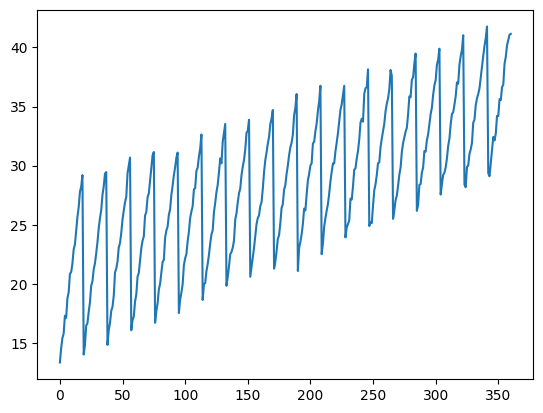

In [105]:
from matplotlib import pyplot as plt
import pandas as pd



In [ ]:
np.random.seed(42)
random.seed(42)

total_boxes = 1000
contamination_rate = 0.01
test_rate = 0.5
test_sensitivity = 0.9

box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx, "H") for farm_idx in range(1, 11) for plot_idx in range(1, 101) for box_idx in range(1, 6)])
contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)

false_negative_counts = []
positive_test_counts = []
for stage in ["H", "D", "R"]:
    box_ids, false_negative_mask, positive_test_mask = run_stage(stage, box_ids, contamination_mask, test_rate)
    false_negative_counts.append(false_negative_mask.sum())
    positive_test_counts.append(positive_test_mask.sum())

print(f"False negative count: {false_negative_counts}")
print(f"Positive test count: {positive_test_counts}")

In [ ]:
import numpy as np
from numba import njit

# Cost Function
test_number = np.zeros(iteration)  # initialize test_number

# calculate unfound_contaminate
unfound_contaminate = history_box_id_r[(contaminate_drop[:, iteration] == 0) & (contaminate_b[:, iteration] == 1)]
unfound_farmid = np.floor(unfound_contaminate / 10000000)
unfound_plotid = np.floor((unfound_contaminate - 10000000 * unfound_farmid) / 1000)
number_unfound = len(unfound_contaminate)

# iterate over history_box_id_cus to find matching contaminated customer
contaminate_customer = []
for i in range(len(history_box_id_cus)):
    cur_farmid = np.floor(history_box_id_cus[i, iteration] / 100000000000000)
    cur_plotid = np.floor((history_box_id_cus[i, iteration] - 100000000000000 * cur_farmid) / 10000000000)
    if (cur_farmid == unfound_farmid).any() and (cur_plotid == unfound_plotid).any():
        contaminate_customer.append(history_box_id_cus[i, iteration])
contaminate_customer = np.array(contaminate_customer)

customer_number = len(contaminate_customer)
ill_number = np.random.rand(customer_number) < ill_rate
hospital_number = np.random.rand(customer_number) < hospital_rate
death_number = np.random.rand(customer_number) < death_rate
death_case_number = np.sum(death_number)
hospital_case_number = np.sum(hospital_number)
ill_case_number = np.sum(ill_number)

# Transportation cost
trans_cost = f_d_trans_cost[iteration] + d_r_trans_cost[iteration]
test_cost = np.sum(f_test_number) * test_cost_f + np.sum(p_test_number) * test_cost_p + np.sum(d_test_number) * test_cost_d + np.sum(r_test_number) * test_cost_r
compensation_cost = ill_case_number * ill_compensation + hospital_case_number * hospital_compensation + death_case_number * death_compensation
recall_cost = (unit_recall_labor_cost + price_per_box) * len(unfound_contaminate) + (unit_trace_labor_cost) * len(unfound_contaminate)
cost_ind = trans_cost + test_cost + compensation_cost + recall_cost



In [84]:
farm_population = 1
plot_per_farm = 5
box_per_plot = 5
box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx, "F")
                    for farm_idx in range(farm_population)
                    for plot_idx in range(plot_per_farm)
                    for box_idx in range(box_per_plot)])
len(box_ids)

25

In [101]:
len(dropped_boxes_C_l)

81

In [96]:
box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(100, 500, 20, 0.05, 0.01, 0.04, 0.05, 0.01, 0.02)
print(len(box_ids))
print(len(box_ids_C))
print(len(dropped_boxes_F))
print(len(dropped_boxes_P))
print(len(dropped_boxes_D))
print(len(dropped_boxes_R))
print(len(dropped_boxes_C))

print(sum([len(dropped_boxes_F), len(dropped_boxes_P), len(dropped_boxes_D), len(dropped_boxes_R), len(dropped_boxes_C), box_ids_C.shape[0]]))

1000000
993830
516
1967
2341
476
870
1000000


In [4]:

def run_stage(stage, box_ids, contamination_mask, test_rate):
    num_boxes = len(box_ids)
    num_tested_boxes = int(num_boxes * test_rate)
    
    # Generate mask for boxes being tested in this stage
    tested_boxes = np.random.choice(num_boxes, num_tested_boxes, replace=False)
    tested_box_ids = box_ids[tested_boxes]
    tested_box_mask = np.zeros(num_boxes, dtype=bool)
    tested_box_mask[tested_boxes] = True
    
    # Generate contamination mask for boxes being tested
    tested_contamination_mask = contamination_mask[tested_box_mask]
    
    # Find tested boxes that are contaminated
    tested_contaminated_boxes = tested_box_ids[tested_contamination_mask]
    dropped_boxes = set()
    
    if tested_contaminated_boxes.size > 0:
        dropped_boxes = set([box_id[:-1] for box_id in tested_contaminated_boxes])
        mask = np.isin(box_ids, list(dropped_boxes))
        box_ids = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
    
    remaining_boxes = box_ids[~np.isin(box_ids, tested_contaminated_boxes)]
    
    return remaining_boxes, contamination_mask, dropped_boxes


def run_stage(stage, box_ids, contamination_mask, test_rate):
    num_boxes = len(box_ids)
    num_tested_boxes = int(num_boxes * test_rate)
    
    # Generate mask for boxes being tested in this stage
    tested_boxes = np.random.choice(num_boxes, num_tested_boxes, replace=False)
    tested_box_ids = box_ids[tested_boxes]
    tested_box_mask = np.zeros(num_boxes, dtype=bool)
    print(tested_box_mask)
    tested_box_mask[tested_boxes] = True
    print(tested_box_mask)
    print(tested_boxes)
    # Generate contamination mask for boxes being tested
    #tested_contamination_mask = contamination_mask[tested_box_mask]
    
    # Find tested boxes that are contaminated
    #tested_contaminated_boxes = tested_box_ids[tested_contamination_mask]

    # Generate contamination mask for boxes being tested
    #tested_box_mask = np.isin(box_ids, tested_boxes)
    tested_contamination_mask = contamination_mask[tested_box_mask]
    
    # Find tested boxes that are contaminated
    tested_contaminated_boxes = box_ids[tested_box_mask][tested_contamination_mask]
    print(tested_contaminated_boxes)

    dropped_boxes = set()
    
    if tested_contaminated_boxes.size > 0:
        dropped_boxes = set([box_id[:-1] for box_id in tested_contaminated_boxes])
        mask = np.isin(box_ids, list(dropped_boxes))
        box_ids = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
    
    remaining_boxes = box_ids[~np.isin(box_ids, tested_contaminated_boxes)]
    
    return remaining_boxes, contamination_mask, dropped_boxes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 9.9 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [21]:
contaminate_b.shape
(31552, 100)
contaminate_drop[:, iteration].shape
(31552,)

(31552, 100)